In [275]:
import pandas as pd
import yfinance as yf
import numpy as np
from scipy import stats
from scipy.optimize import minimize

# Step 1 - Download data

In [276]:
tickers = ['AAPL', 'JNJ', 'META', 'NVDA', 'PFE', 'SPY']

In [277]:
prices = yf.download(tickers, start = '2013-01-01', end = '2019-01-01')
prices = prices.resample('ME').last()
ret = prices['Close'].pct_change()[1:]
print(ret.tail())

[*********************100%***********************]  6 of 6 completed

Ticker          AAPL       JNJ      META      NVDA       PFE       SPY
Date                                                                  
2018-08-31  0.200422  0.023148  0.018253  0.146915  0.048673  0.031920
2018-09-30 -0.008303  0.025837 -0.064132  0.001211  0.061416  0.005945
2018-10-31 -0.030478  0.013172 -0.077040 -0.249769 -0.022918 -0.069104
2018-11-30 -0.181198  0.056043 -0.073654 -0.224050  0.081903  0.018549
2018-12-31 -0.116698 -0.121511 -0.067705 -0.183136 -0.055808 -0.088048


In [278]:
ret = ret.dropna()

# Step 2 -Sample statistics

In [279]:
#Mean, Variance, and Beta
retmean_SPY = ret['SPY'].mean()
retvar_SPY = ret['SPY'].var()
beta_SPY = stats.linregress(ret['SPY'],ret['SPY']).slope

retmean_AAPL = ret['AAPL'].mean()
retvar_AAPL = ret['AAPL'].var()
beta_AAPL = stats.linregress(ret['SPY'],ret['AAPL']).slope

retmean_NVDA = ret['NVDA'].mean()
retvar_NVDA = ret['NVDA'].var()
beta_NVDA = stats.linregress(ret['SPY'],ret['NVDA']).slope

retmean_PFE = ret['PFE'].mean()
retvar_PFE = ret['PFE'].var()
beta_PFE = stats.linregress(ret['SPY'],ret['PFE']).slope

retmean_JNJ = ret['JNJ'].mean()
retvar_JNJ = ret['JNJ'].var()
beta_JNJ = stats.linregress(ret['SPY'],ret['JNJ']).slope

retmean_META = ret['META'].mean()
retvar_META = ret['META'].var()
beta_META = stats.linregress(ret['SPY'],ret['META']).slope

retmean = np.array([retmean_AAPL, retmean_JNJ, retmean_META, retmean_NVDA, retmean_PFE,  retmean_SPY])
retvar = np.array([retvar_AAPL, retvar_JNJ, retvar_META, retvar_NVDA, retvar_PFE, retvar_SPY])
betas = np.array([beta_AAPL, beta_JNJ, beta_META, beta_NVDA, beta_PFE, beta_SPY])

In [280]:
#CAPM to find alphas

r_free = 0.01

alpha_AAPL = retmean_AAPL - r_free - beta_AAPL*(retmean_SPY - r_free)
alpha_NVDA = retmean_NVDA - r_free - beta_NVDA*(retmean_SPY - r_free)
alpha_PFE = retmean_PFE - r_free - beta_PFE*(retmean_SPY - r_free)
alpha_META = retmean_META - r_free - beta_META*(retmean_SPY - r_free)
alpha_JNJ = retmean_JNJ - r_free - beta_JNJ*(retmean_SPY - r_free)
alpha_SPY = retmean_SPY - r_free - beta_SPY*(retmean_SPY - r_free)
alphas = np.array([alpha_AAPL, alpha_JNJ, alpha_META, alpha_NVDA, alpha_PFE, alpha_SPY])


In [281]:
# Idiosyncratic Risk
idio_risk_AAPL = retvar_AAPL - np.square(beta_AAPL)*retvar_SPY
idio_risk_JNJ = retvar_JNJ - np.square(beta_JNJ)*retvar_SPY
idio_risk_META = retvar_META - np.square(beta_META)*retvar_SPY
idio_risk_NVDA = retvar_NVDA - np.square(beta_NVDA)*retvar_SPY
idio_risk_PFE = retvar_PFE- np.square(beta_PFE)*retvar_SPY
idio_risk_SPY = retvar_SPY - np.square(beta_SPY)*retvar_SPY

idio_risks = np.array([idio_risk_AAPL, idio_risk_JNJ, idio_risk_META, idio_risk_NVDA, idio_risk_PFE, idio_risk_SPY])

df = pd.DataFrame({'Mean': retmean, 'Variance': retvar, 'Beta': betas, 'Alpha': alphas, 'Idio Risk':idio_risks}, index=tickers)
print(df)

          Mean  Variance      Beta     Alpha  Idio Risk
AAPL  0.016851  0.005383  1.221579  0.007579   0.003970
JNJ   0.011060  0.001646  0.791564  0.001531   0.001052
META  0.024189  0.008211  0.755036  0.014638   0.007671
NVDA  0.041021  0.012284  1.787728  0.032085   0.009256
PFE   0.010443  0.001909  0.855174  0.000952   0.001216
SPY   0.009405  0.000947  1.000000  0.000000   0.000000


# Step 3 - Portfolio's E(R), SD, SR

In [282]:
# Variance - Covariance Matrix

cov = ret.cov() * 12 # Annualize the covariance matrix
print(cov)

Ticker      AAPL       JNJ      META      NVDA       PFE       SPY
Ticker                                                            
AAPL    0.064599  0.008506  0.020929  0.043347  0.005524  0.013887
JNJ     0.008506  0.019748  0.002354  0.006513  0.012566  0.008999
META    0.020929  0.002354  0.098527  0.013013  0.002904  0.008584
NVDA    0.043347  0.006513  0.013013  0.147406  0.004451  0.020324
PFE     0.005524  0.012566  0.002904  0.004451  0.022906  0.009722
SPY     0.013887  0.008999  0.008584  0.020324  0.009722  0.011368


In [283]:
# We calculte portfolio's standard deviation

def standard_deviation(weights, cov):
    variance = weights.T @ cov @ weights
    return np.sqrt(variance)



In [284]:
# We calculate portfolio's expected return
def expected_return(weights, retmean):
    return weights @ retmean * 12 # Annualize the expoected return

In [285]:
# We calculate portfolio's Sharpe Ratio
def sharpe_ratio(weights, retmean, cov, r_free):
    return(expected_return(weights, retmean) - r_free) / standard_deviation(weights, cov)

# Step 4 - Optimization

In [286]:
# We retrieve risk free rate from FED
from fredapi import Fred

fred = Fred(api_key = 'dc20e57c84606fbf0c666d5255182c4b')
ten_year_treasury_rate = fred.get_series_latest_release('GS10')/100

risk_free_rate = ten_year_treasury_rate.iloc[-1]
print(risk_free_rate)

0.043899999999999995


In [287]:
# Negative SR function because there is no maximization function in scipy

def negative_sharpe_ratio(weights, retmean, cov, risk_free_rate):
    return -sharpe_ratio(weights, retmean, cov, risk_free_rate)

In [288]:
# We set the constraints for the optimization

constraints = {'type' : 'eq', 'fun' : lambda weights: np.sum(weights) - 1}
bounds = [(0,0.20) for i in range(len(tickers))]

In [289]:
# We set initial weights
initial_weights = np.array([1/len(tickers)]*len(tickers))
print(initial_weights)

[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]


In [290]:
# we optimize weights

optimized_weights = minimize(negative_sharpe_ratio, initial_weights, args=(retmean, cov, risk_free_rate), method='SLSQP', constraints=constraints, bounds=bounds)

In [291]:
# We print optimal weights

optimal_weights = optimized_weights.x # x is to access the optimal weights

# Step 5 - display analytics of optimal portfolio

In [292]:
print("Optimal Weights")

for tickers, weight in zip(tickers, optimal_weights):
    print(f"{tickers}: {weight: .3%}") 

print()

optimal_portfolio_return =expected_return(optimal_weights, retmean)
optimal_portfolio_volatility =standard_deviation(optimal_weights, cov)
optimal_sharpe_ratio = sharpe_ratio(optimal_weights, retmean, cov, risk_free_rate)

print(f"Expected Annual Return: {optimal_portfolio_return: .4%}")
print(f"Expected Volatility: {optimal_portfolio_volatility: .2%}")
print(f"Expected Annual Return: {optimal_sharpe_ratio: .4f}")

Optimal Weights
AAPL:  5.615%
JNJ:  20.000%
META:  20.000%
NVDA:  20.000%
PFE:  20.000%
SPY:  14.385%

Expected Annual Return:  23.5698%
Expected Volatility:  14.16%
Expected Annual Return:  1.3545


# Step 6 - Plotting

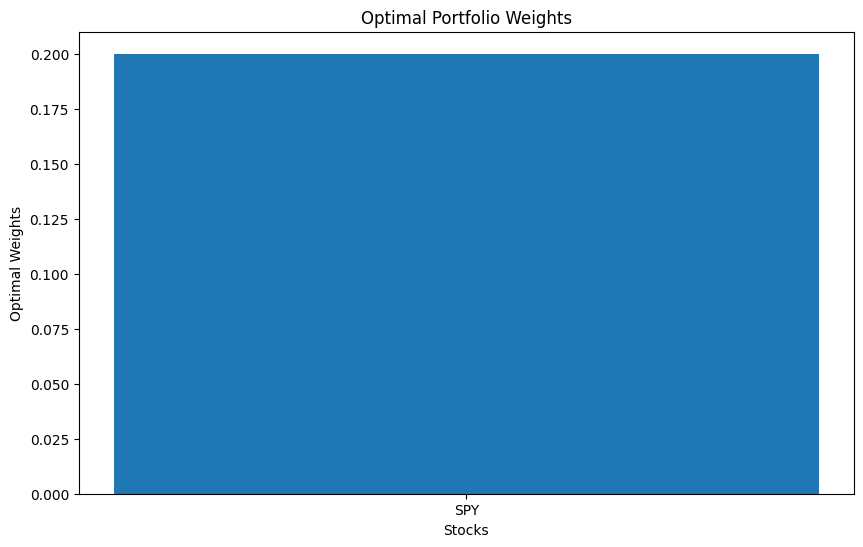

In [293]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.bar(tickers, optimal_weights)

#Add labels
plt.xlabel('Stocks')
plt.ylabel('Optimal Weights')
plt.title('Optimal Portfolio Weights')

plt.show()